# Метод частичной дискретизации с условиями излучения

$$\begin{cases}
u_{xx}+u_{yy}+\varkappa^2 \rho(x,y)\ u=f(x,y),\quad (x,y)\in(0,a)\times(0,b), \\
u(x,0)=u(x,b)=0, \\
f(x,y) \equiv 0,\quad \text{при}\ x\not\in [0,a].
\end{cases}$$

In [1424]:
using ProgressMeter

"""
A, B, C - вектор матриц, F - массив векторов. \n
Если, например, А - матрица, считаем, что предполагается вектор одинаковых матриц. \n
Если и A, и B, и С, и F - не векторы, длина вектора решения указывается через аргумент len.
"""
function matrix_thomas(A, B, C, F; typ=Float64, len=1, F_left=nothing)
    v = filter(a->!(eltype(a) <: Number),[A,B,C,F])
    N = len == 1 ? length(v[1]) : len
    K = len == 1 ? size(v[1][1],1) : size(A,1)
    
    pr = Progress(N, 1)
    
    a = zeros(typ,K,K,N+1)
    b = zeros(typ,K,N+1)

    inside(a,b) = true in map(el->isequal(el,a),b)
    
    An = inside(A,v) ? n->A[n] : n->A
    Bn = inside(B,v) ? n->B[n] : n->B
    Cn = inside(C,v) ? n->C[n] : n->C
    Fn = inside(F,v) ? n->F[n] : n->F
#     An, Bn, Cn, Fn = map(i->inside(i,v) ? n->i[n] : n->i, [A,B,C,F])

    for n = 1:N
        a[:,:,n+1] = -Cn(n) / (An(n)*a[:,:,n] + Bn(n))
        b[:,n+1] = (Fn(n) - An(n)*b[:,n])' / (An(n)*a[:,:,n] + Bn(n))
        next!(pr)    # update progress bar
    end

    x = zeros(typ,K,N+1)
    for n = N:-1:1
        x[:,n] = a[:,:,n+1]*x[:,n+1] + b[:,n+1]
    end

    return x[:,1:N]
end

matrix_thomas

In [2766]:
a, b = 2, 1
a1, a2 = 0.5, 1.5
r1, r2 = 1, 3
# k = sqrt((16*pi/b)^2/r2+(16*pi/a)^2/r1)
k = 26.5

K = 16
N_ = 200
h = a/(N_-1)
x = range(0,stop=a,length=N_)
y = range(0,stop=b,length=200)

mu(k) = pi*k/b
f(y,k) = sqrt(2/b)*sin(pi*k/b*y)

f (generic function with 2 methods)

In [2767]:
f(x) = 0.2*(x-a1)/(a2-a1)
g(x) = x <= a1 ? 0 : x <= a2 ? f(x) : 0.2

f1 = x -> b/2-0.1 - g(x)
f2 = x -> b/2 - g(x)
f3 = x -> b/2 + g(x)
f4 = x -> b/2+0.1 + g(x)

#3461 (generic function with 1 method)

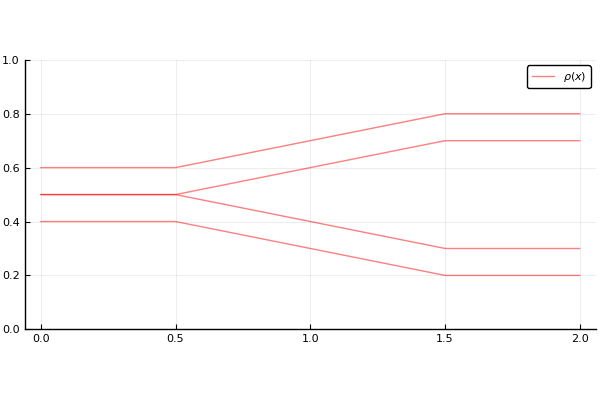

In [2768]:
using LaTeXStrings
using Plots
pyplot(fmt="png")

plot( x, f1.(x), c=:red, alpha=0.5, ylim=(0,b), aspect_ratio=1, label=L"\rho(x)")
plot!(x, f2.(x), c=:red, alpha=0.5, label="")
plot!(x, f3.(x), c=:red, alpha=0.5, label="")
plot!(x, f4.(x), c=:red, alpha=0.5, label="")

In [2769]:
using LinearAlgebra
using SymPy

y1 = Sym("y")
k1,k2 = symbols("k_1 k_2", positive=true, integer=true)
ff = simplify(integrate( 2/Sym(b)*sin(pi*k1/Sym(b)*y1)*sin(pi*k2/Sym(b)*y1), y1 ))

⎧2⋅(-k₁⋅sin(π⋅k₂⋅y)⋅cos(π⋅k₁⋅y) + k₂⋅sin(π⋅k₁⋅y)⋅cos(π⋅k₂⋅y))             
⎪────────────────────────────────────────────────────────────  for k₁ ≠ k₂
⎪                         ⎛  2     2⎞                                     
⎪                       π⋅⎝k₁  - k₂ ⎠                                     
⎪                                                                         
⎨                            sin(2⋅π⋅k₂⋅y)                                
⎪                   π⋅k₂⋅y - ─────────────                                
⎪                                  2                                      
⎪                   ──────────────────────                      otherwise 
⎪                            π⋅k₂                                         
⎩                                                                         

\begin{equation*} \int\limits_0^b\varphi_{k_1}(y)\rho(x_n,y)\varphi_{k_2}(y)dy = 
   \begin{cases}
   I_1,\ x_n\in (0,a_1), \\
   I_2,\ x_n\in [a_1,a_2], \\
   I_3,\ x_n\in (a_2,a).
   \end{cases}
\end{equation*}
$I_1 = \rho_1\delta_{k_1,k_2} + (\rho_2-\rho_1)\int\limits_{\frac{b}{2}-0.1}^{\frac{b}{2}+0.1}
\varphi_{k_1}\varphi_{k_2}dy,$  
$I_2 = \rho_1\delta_{k_1,k_2} + (\rho_2-\rho_1)\int\limits_{\frac{b}{2}-0.1-f(x_n)}^{\frac{b}{2}-f(x_n)}
\varphi_{k_1}\varphi_{k_2}dy  + (\rho_2-\rho_1)\int\limits_{\frac{b}{2}+f(x_n)}^{\frac{b}{2}+0.1+f(x_n)}
\varphi_{k_1}\varphi_{k_2}dy,$  
$I_3 = \rho_1\delta_{k_1,k_2} + (\rho_2-\rho_1)\int\limits_{\frac{b}{2}-0.3}^{\frac{b}{2}-0.2}
\varphi_{k_1}\varphi_{k_2}dy  + (\rho_2-\rho_1)\int\limits_{\frac{b}{2}+0.2}^{\frac{b}{2}+0.3}
\varphi_{k_1}\varphi_{k_2}dy,$

In [2770]:
ff_ij = lambdify(evalf( ff[:args]()[1][:args]()[1] ),[k1,k2,y1])
ff_ii = lambdify(evalf( ff[:args]()[2][:args]()[1] ),[k2,y1])
I_ij(i,j,n)   = ff_ij(i,j,f4(x[n]))-ff_ij(i,j,f3(x[n]))+ff_ij(i,j,f2(x[n]))-ff_ij(i,j,f1(x[n]))
I_ii(i,n)     = ff_ii(i,  f4(x[n]))-ff_ii(i,  f3(x[n]))+ff_ii(i,  f2(x[n]))-ff_ii(i,  f1(x[n]))

function YrY(n,K)
    global r1,r2
    yry = zeros(K,K)
    for i=1:K, j=i+1:K
        yry[i,j] = I_ij(i,j,n)
        yry[j,i] = yry[i,j]
    end
    for i=1:K
        yry[i,i] = I_ii(i,n)
    end
    return  I*r1 + (r2-r1)*yry
end

YrY (generic function with 1 method)

In [2771]:
using LinearAlgebra

M_square = diagm(0=>mu.(1:K).^2)
A1 = k^2*YrY(1,K) - M_square
L1 = reverse(eigvals(A1))
J = filter(z->L1[z]>0,1:K)

9-element Array{Int64,1}:
 1
 2
 3
 4
 5
 6
 7
 8
 9

In [2772]:
Z1 = reverse(eigvecs(A1), dims=2);

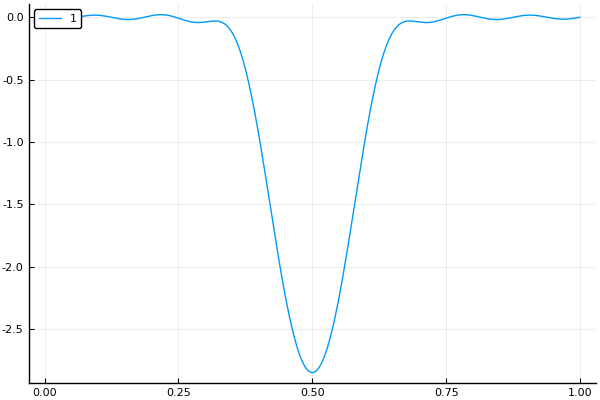

In [2773]:
cross_section(y,n) = sum([f(y,i)*Z1[i,n] for i=1:K])

plot(legend=:topleft)
for i in J[1:1]
    plot!(y, cross_section.(y,i), label="$i")
end
plot!()

Невязка:
$r_n(y)=\Psi_1 C_1(\varkappa^2\rho(x_0,y)-\gamma_n^2-\mu_1^2)+\dotso+\Psi_K C_K (\varkappa^2\rho(x_0,y)-
  \gamma_n^2-\mu_K^2)$

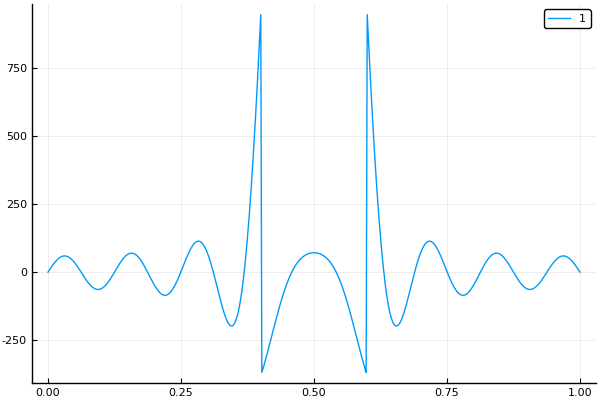

In [2774]:
residual(y0,n) = sum([f(y0,i)*Z1[i,n]*(k^2*(z -> f1(0)<z<f4(0) ? r2 : r1)(y0)-L1[n]-mu(i)^2) for i=1:K])
plot()
for k in J[1:1]
    plot!(0:b/500:b,residual.(0:b/500:b,k),label="$k")
end
plot!()

In [2775]:
sqrt.(L1[J]).-k

9-element Array{Float64,1}:
  17.66957981782935  
  12.292327376756568 
   2.5345504176500704
  -1.083946894810552 
  -1.4525049085391224
  -4.5117622916127935
  -5.835431332178327 
 -11.30941189426187  
 -15.563346992987743 

In [2776]:
sqrt(L1[J[1]])

44.16957981782935

In [2777]:
gamma1 = sqrt.(Complex.(L1))
G1 = diagm(0=>gamma1);

Условия излучения:  
$\begin{cases}
\left.(i\Gamma_{(1)} X+X')\right|_{x=0} = 2i\Gamma_{(1)} A, \\
\left.(i\Gamma_{(3)} X-X')\right|_{x=a} = 2i\Gamma_{(3)} B.
\end{cases}$

### Регулярная часть волновода (слева)

In [2778]:
A = diagm(0=>ones(K))
B_reg = fill(-2*I - h^2*M_square + h^2*k^2*YrY(1,K),  N_-2)
B_reg = [[B_reg[1]/2+h*im*G1]; B_reg; [B_reg[1]/2+h*im*G1]]
C_ = diagm(0=>ones(K));

In [2779]:
A_I_reg = [1; zeros(K-1)]
F0_reg = 2h*im*G1*A_I_reg
F_reg = [[F0_reg]; fill(zeros(K),N_-1)];

In [2780]:
X_reg = matrix_thomas(A,B_reg,C_,F_reg,typ=Complex);

In [2781]:
u_reg = reshape([dot(f.(y_i,1:K), real.(X_reg[1:K,n])) for n=1:N_ for y_i in y], length(y), length(x));

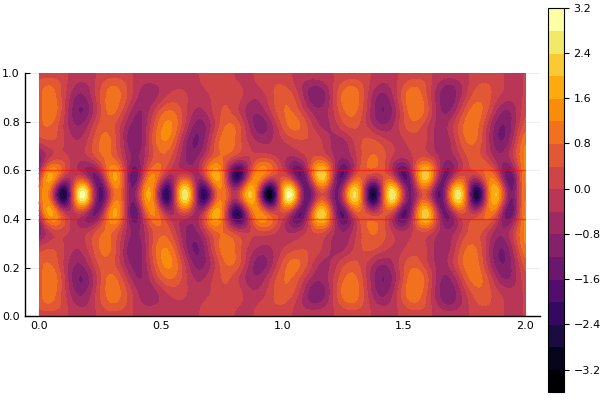

In [2782]:
plot(x,y,real.(u_reg),fill=true,aspect_ratio=1)
plot!(x, 0*x.+(b/2-0.1), c=:red, alpha=0.5, ylim=(0,b), aspect_ratio=1, leg=false)
plot!(x, 0*x.+(b/2+0.1), c=:red, alpha=0.5)
# savefig("reg_wg.png")

In [2783]:
A_I_test = [1; zeros(K-1)]
# nu_I  = diagm(0=>(i->i-sqrt(i^2-1)).(L1[end-K+1:end]))
nu_I  = diagm(0=>(i->i+sqrt(i^2-1)).(L1))^-1
A_test = [fill(A,N_-1); [-nu_I*Z1^-1]]
B_test = [[Z1^-1]; B_reg; [Z1^-1]]
C_test = [[-nu_I*Z1^-1]; fill(C_,N_-1)]
F_test = [[(A-nu_I.^2)*A_I_test]; fill(zeros(K),N_-1)];

In [2784]:
abs(nu_I[1]) < 1

true

In [2785]:
X_test = matrix_thomas(A_test,B_test,C_test,F_test,typ=Complex);

In [2786]:
u_test = reshape([dot(f.(y_i,1:K), real.(X_test[1:K,n])) for n=1:N_ for y_i in y], length(y), length(x));

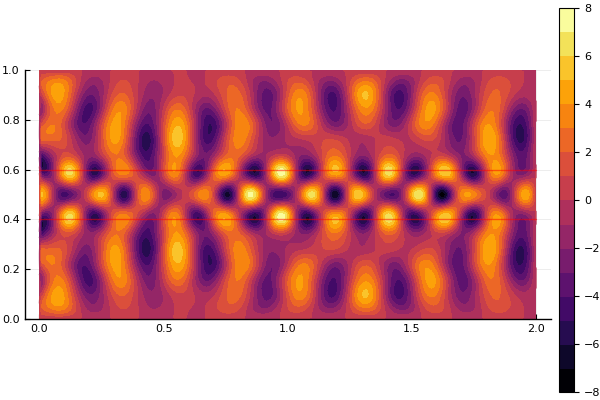

In [2787]:
plot(x,y,real.(u_test),fill=true,aspect_ratio=1)
plot!(x, 0*x.+(b/2-0.1), c=:red, alpha=0.5, ylim=(0,b), aspect_ratio=1, leg=false)
plot!(x, 0*x.+(b/2+0.1), c=:red, alpha=0.5)

### Расщепление волновода

In [2788]:
A3 = k^2*YrY(N_,K) - M_square
L3 = reverse(eigvals(A3))
Z3 = reverse(eigvecs(A3), dims=2)
gamma3 = sqrt.(Complex.(L3))
G3 = diagm(0=>gamma3);

In [2789]:
B1 = fill(-2*I - h^2*M_square + h^2*k^2*YrY(1,K),  sum(x .<= a1)-1)
B2 =     [-2*I - h^2*M_square + h^2*k^2*YrY(n,K) for n in filter(i->(a1 .< x[i] .< a2),1:N_)]
B3 = fill(-2*I - h^2*M_square + h^2*k^2*YrY(N_,K), sum(a2 .<= x .<= a)-1)
B = [[B1[1]/2+h*im*G1]; B1; B2; B3; [B3[1]/2+h*im*G3]]
C_ = diagm(0=>ones(K));

In [2790]:
A_I = [1; zeros(K-1)]
F0 = 2h*im*G1*A_I
F = [[F0]; fill(zeros(K),N_-1)];

In [2791]:
X_in = matrix_thomas(A,B,C_,F,typ=Complex);

In [2792]:
u = reshape([dot(f.(y_i,1:K), X_in[1:K,n]) for n=1:N_ for y_i in y], length(y), length(x));

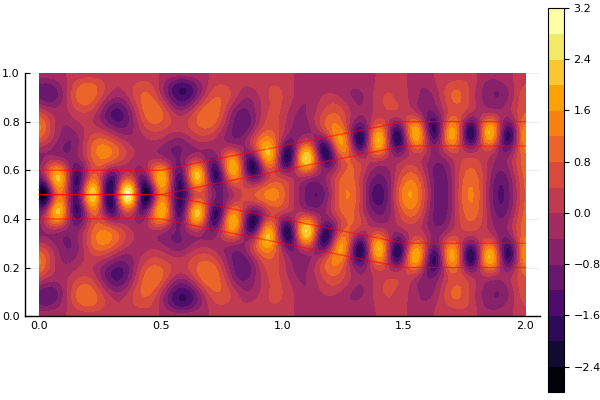

In [2793]:
plot(x,y,real.(u),fill=true,aspect_ratio=1)
plot!(x, f1.(x), c=:red, alpha=0.5, ylim=(0,b), aspect_ratio=1, leg=false)
plot!(x, f2.(x), c=:red, alpha=0.5)
plot!(x, f3.(x), c=:red, alpha=0.5)
plot!(x, f4.(x), c=:red, alpha=0.5)
# savefig("wg_1.png")

In [2794]:
nu_I  =  diagm(0=>(i->i-sqrt(i^2-1)).(L1))
nu_III = diagm(0=>(i->i-sqrt(i^2-1)).(L3))
A_seq = [fill(A,N_-1); [-nu_III*Z3^-1]]
B_seq = [[Z1^-1]; B1; B2; B3; [Z3^-1]]
C_seq = [[-nu_I*Z1^-1]; fill(C_,N_-1)]
F_seq = [[(A-nu_I.^2)*A_I]; fill(zeros(K),N_-1)];

In [2795]:
X_seq = matrix_thomas(A_seq,B_seq,C_seq,F_seq,typ=Complex);

In [2796]:
u_seq = reshape([dot(f.(y_i,1:K), X_seq[1:K,n]) for n=1:N_ for y_i in y], length(y), length(x));

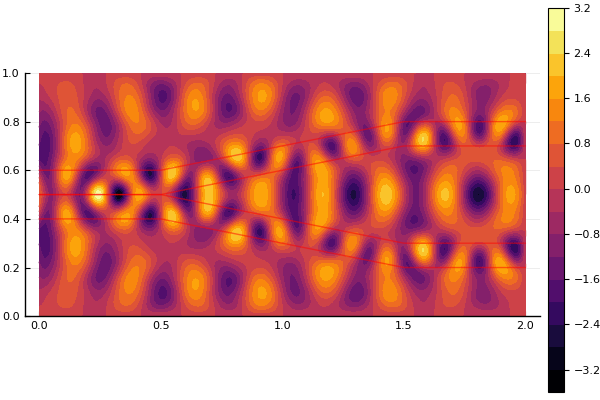

In [2797]:
plot(x,y,real.(u_seq),fill=true,aspect_ratio=1)
plot!(x, f1.(x), c=:red, alpha=0.5, ylim=(0,b), aspect_ratio=1, leg=false)
plot!(x, f2.(x), c=:red, alpha=0.5)
plot!(x, f3.(x), c=:red, alpha=0.5)
plot!(x, f4.(x), c=:red, alpha=0.5)
# savefig("wg_seq.png")